In [4]:
import torch
from torch import tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import botorch.acquisition as acqf
import numpy as np
from matplotlib import pyplot as plt
import random
%matplotlib inline
from test_functions import himmelblau
from plot import *

## Optimizing Test Functions with EI

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

dtype = torch.double

In [ ]:
x_ = torch.arange(-1.0, 1.0, 0.01)
y_ = torch.arange(-1.0, 1.0, 0.01)
x_axis, y_axis = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_axis, y_axis), 2))

X_ = grid.reshape(len(x_)*len(y_), 2)

## Bayesian Optimization

::::::::::::::::::::::::::::::::::::::::::::::::::::
Sample  0
initialization
candidate:  tensor([-0.0075,  0.5364], dtype=torch.float64)
model score for candidate:  0.0819171632108554
iteration:       0
iteration:       1
iteration:       2
iteration:       3
iteration:       4
iteration:       5
iteration:       6
iteration:       7
iteration:       8
iteration:       9
iteration:       10
iteration:       11
iteration:       12
iteration:       13
iteration:       14
::::::::::::::::::::::::::::::::::::::::::::::::::::
Sample  1
initialization
candidate:  tensor([ 0.6072, -0.2795], dtype=torch.float64)
model score for candidate:  0.01676338953078953
iteration:       0
iteration:       1
iteration:       2
iteration:       3
iteration:       4
iteration:       5
iteration:       6
iteration:       7
iteration:       8
iteration:       9
iteration:       10
iteration:       11
iteration:       12
iteration:       13
iteration:       14
:::::::::::::::::::::::::::::::::::::::::::::::::

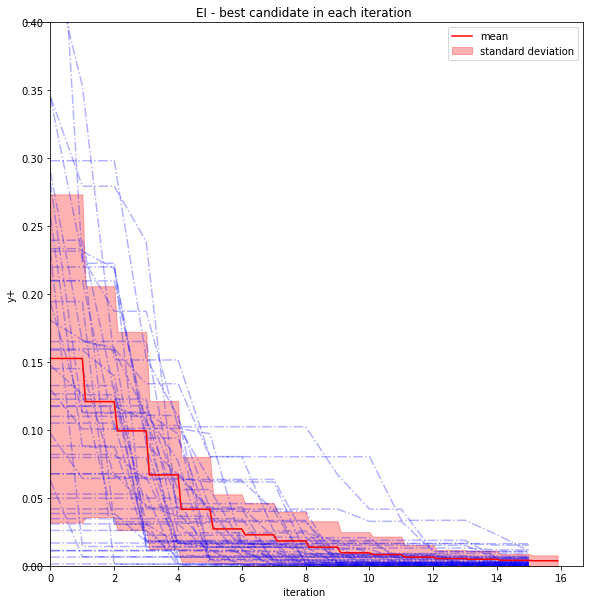

In [6]:
def sample_bo(n_iters:int, plot=False):
    bounds = tensor([[x_[0], y_[0]], [x_[-1], y_[-1]]])

    X_samples = tensor([[2 * torch.rand((1)) - 1, 2 * torch.rand((1)) - 1]], dtype=torch.double)
    y_samples = torch.tensor([[himmelblau(X_samples[:,0], X_samples[:,1])]], dtype=torch.double)#.reshape(-1, 1)

    print("=======================")
    print("initialization")
    print("candidate: ", X_samples[0])
    print("model score for candidate: ", float(y_samples[0]))

    for i in range(n_iters):
        print("=======================")
        print("iteration:      ", i)
        #print(X_samples)
        gp = SingleTaskGP(X_samples, y_samples)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        EI = acqf.ExpectedImprovement(
            gp,
            y_samples.min(),
            maximize=False
        )

        # plot
        if plot:
            plot_bo(gp, EI, X_samples)

        best_candidate, acq_value = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=1,
            num_restarts=1,
            raw_samples=20
        )

        y_new_sample = himmelblau(best_candidate[0][0],
                                            best_candidate[0][1])
        #print("candidate: ", best_candidate)
        #print("model score for candidate: ", float(y_new_sample))

        X_samples = torch.vstack((X_samples, best_candidate))
        y_samples = torch.vstack((y_samples, y_new_sample))
    return y_samples


# params
n_samples = 50
n_bo = 15

plot = False

# measurements
improvement_mean = torch.zeros((n_bo+1, 1))
improvement_list = []
# bo sampling loop
p, ax = plt.subplots(figsize=(10, 10))

# only plot current best
# show simulated computation time on x-axis
for i in range(0, n_samples):
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::")
    print("Sample ", i)
    result = sample_bo(n_bo, plot=plot)
    improvement = torch.tensor([result[0]])

    for j in range(1, len(result)):
        if improvement[-1] > result[j]:
            improvement = torch.vstack((improvement, result[j]))
        else:
            improvement = torch.vstack((improvement, improvement[-1]))

    improvement_mean += improvement
    improvement_list.append(improvement)
    ax.plot(np.arange(0, len(improvement), 1),
            improvement,
            '-.',
            color='blue',
            alpha = 0.3)

compute_time_steps = torch.arange(0, n_bo+1, 0.1)
improvement_list_scaled = []
for i in range(0, len(improvement_list)):
    current_improvement = improvement_list[i]
    current_compute_time = torch.arange(0, n_bo+1, 1)
    scaled_improvement = torch.zeros((len(compute_time_steps)), 1)
    iter = 0
    compute_time = 0
    for j in range(0, len(compute_time_steps)):
        imp = current_improvement[iter]
        if not iter + 1 > len(current_compute_time) -1:
            compute_time = current_compute_time[iter+1]
        scaled_improvement[j] = imp
        if compute_time_steps[j] >= compute_time:
            if iter < len(current_improvement)-1:
                iter += 1
    improvement_list_scaled.append(scaled_improvement)

# calculate mean
improvement_mean = torch.zeros((len(compute_time_steps), 1))
for improvement in improvement_list_scaled:
    improvement_mean += improvement
improvement_mean *= 1/n_samples

# calculate var
improvement_var = torch.zeros((len(improvement_mean), 1))
for i in range(0, n_samples):
    improvement_var += torch.square(improvement_list_scaled[i] - improvement_mean)
improvement_var *= 1/n_samples
improvement_var = torch.sqrt(improvement_var)

print("improvement_mean: ", improvement_mean)
print("improvement_var: ", improvement_var)

ax.plot(compute_time_steps,
        improvement_mean,
        color='red',
        label='mean')
ax.fill_between(compute_time_steps,
                (improvement_mean - improvement_var).flatten(),
                (improvement_mean + improvement_var).flatten(),
                alpha=0.3,
                color='red',
                label='standard deviation')
print("MEAN: ", improvement_mean)
print("VAR: ", improvement_var)
print("MEAN MAX: ", max(improvement_mean))
print("MEAN MIN: ", min(improvement_mean))
ax.set_xlabel("iteration")
ax.set_ylabel("y+")
ax.set_title("EI - best candidate in each iteration")
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.set_ylim([0., 0.4])
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')
#ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')

ax.legend()
plt.show()




#plot_test_func()